<h1 style="font-size:2.2em; font-weight:bold; text-align:center;">Exploratory Data Analysis</h1>

This project serves as a **Proof of Concept (PoC)** to explore **anomaly scoring** techniques for detecting potentially fraudulent banking transactions.

The data covers the period from **April 2, 2025** to **April 4, 2025**, based on the assumption that in mid-2025, trade tensions lead to increased abnormal or suspicious transaction activities.

For exploratory data analysis (EDA), we will:

- Integrate dynamic currency conversion using the Riksbanken API.

- Explore missing values.

- Conduct descriptive analytics using SQL.

- Perform univariate and bivariate analysis to analyze data distribution and identify outliers.





| **Key Findings**                                                                                 |
|--------------------------------------------------------------------------------------------------|
| Dataset merged from `transaction records`, `KYC customer profiles`, and `customer summary statistics`. |
| Contains 10,716 transactions with 41 features (31 categorical, 10 numerical).                      |
| Includes 107 duplicate records.                                                                  |
| All amounts in different currencies have been converted to EUR.                                  |
| Missing values are present in some categorical features.                                         |
| Several numerical features contain potential outliers.             |
| Categorical features exhibit a mix of low and high cardinality.     |       





## <h2 style="font-size: 1.6em; font-weight: bold;"> 1. Data Collection </h2>
Import Required Packages and Data

**Importing Pandas, Numpy, Matplotlib, Seaborn, Plotly.express and Warings Library.**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import plotly.express as px
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

**Import the CSV Data as Pandas DataFrame**

In [2]:
#Import data from 3 reports and merge them using a left join on `customer_id`

transaction_df = pd.read_csv('data/transactions.csv')
customer_df = pd.read_csv('data/customers.csv')
sum_statistic_df = pd.read_csv('data/customer_summary_statistics.csv')

df = transaction_df.merge(customer_df, on='customer_id', how='left') \
                   .merge(sum_statistic_df, on='customer_id', how='left')

Handle duplicate columns after merging.

In [3]:
dup_cols = []
cols = df.columns.tolist()

for i in range(len(cols)):
    for j in range(i + 1, len(cols)):
        if df[cols[i]].equals(df[cols[j]]):
            dup_cols.append((cols[i], cols[j]))
print("Columns with identical values:")
for c1, c2 in dup_cols:
    print(f"{c1} and {c2}")
    
dropped = set()
kept = set()

for c1, c2 in dup_cols:
    if c2 not in dropped:
        df.drop(columns=c2, inplace=True)
        dropped.add(c2)
        kept.add(c1)     
print("Dropped columns:", list(dropped))
print ("Remaining columns:", list(kept) )

Columns with identical values:
currency_x and currency_y
currency_x and currency
amount and amount_f
country_x and nationality
country_x and country_y
currency_y and currency
available_balance_x and booked_balance
available_balance_x and available_balance_y
booked_balance and available_balance_y
credit_limit_x and credit_limit_y
nationality and country_y
Dropped columns: ['credit_limit_y', 'currency', 'country_y', 'currency_y', 'nationality', 'available_balance_y', 'amount_f', 'booked_balance']
Remaining columns: ['currency_x', 'available_balance_x', 'amount', 'credit_limit_x', 'country_x']


In [4]:
df.rename(columns={
    'available_balance_x': 'available_balance',
    'country_x' : 'country',
    'currency_x': 'currency',
    'credit_limit_x' : 'credit_limit'
}, inplace=True)

**Dataset Overview**

In [5]:
df.shape

(10716, 41)

In [6]:
df.dtypes.value_counts()

object     31
float64     8
int64       2
Name: count, dtype: int64

We have a dataset with 10,716 records and 41 columns:

  - Categorical features: 31

  - Numeric features: 10

## <h2 style="font-size: 1.6em; font-weight: bold;"> 2. Data Cleaning </h2>

- Removed Duplicate Entries

- Converted amounts to EUR using exchange rates from the Riskbanken open API

In [7]:
df.duplicated().sum()

107

The data has 107 duplicate records. Drop all duplicate entries.

In [8]:
#Remove Duplicate
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

Standardize all amount-related columns to EUR to ensure consistency for future analysis.

*Using dynamic exchange rates from the Riksbanken API.* 

In [9]:
from datetime import datetime, timedelta
import urllib.request, json


# Ensure all currency codes are uppercase
currencies = df['currency'].unique()

# Build currency-to-series map
currency_to_series = {
    cur: f'SEK{cur}PMI' if cur != 'SEK' else 'SEK'
    for cur in currencies
}

rate_dict = {}

# Loop to fetch exchange rates
for cur in currencies:
    if cur == 'EUR':
        rate_dict[cur] = 1.0  # EUR to EUR
        continue
    if cur == 'SEK':
        series1 = 'SEK'
    else:
        series1 = currency_to_series[cur]

    series1 = currency_to_series[cur]
    url = f'https://api.riksbank.se/swea/v1/CrossRates/{series1}/SEKEURPMI/2025-04-4/2025-04-4' 
    try:
        req = urllib.request.Request(url)
        req.get_method = lambda: 'GET'
        response = urllib.request.urlopen(req)
        content = response.read()
        data = json.loads(content)

        # Handle different JSON structures
        if isinstance(data, list) and data:
            rate = data[0]['value']
            rate_dict[cur] = float(rate)
        elif isinstance(data, dict) and 'value' in data:
            rate_dict[cur] = float(data['value'])
        else:
            rate_dict[cur] = 1.0

    except Exception as e:
        print(f"Error fetching rate for {cur}: {e}")
        rate_dict[cur] = 1.0

cols_to_convert = [
    'amount', 'available_balance', 'value_dated_balance', 'credit_limit',
    'total_volume', 'avg_amount', 'max_amount', 'min_amount'
]
cols_after_convert = []

for col in cols_to_convert:
    new_col = col + '_eur'
    df[new_col] = df.apply(
        lambda x: float(x[col]) if x['currency'].upper() == 'EUR'
        else (
            float(x[col]) / rate_dict.get('SEK', 1.0) if x['currency'].upper() == 'SEK'
            else float(x[col]) * rate_dict.get(x['currency'].upper(), 1.0)
        ),
        axis=1
    )
    cols_after_convert.append(new_col)

In [10]:
print (cols_after_convert)

['amount_eur', 'available_balance_eur', 'value_dated_balance_eur', 'credit_limit_eur', 'total_volume_eur', 'avg_amount_eur', 'max_amount_eur', 'min_amount_eur']


In [11]:
df.drop(columns=cols_to_convert, inplace=True)

In [12]:
df.to_csv('data/RAW_transaction_monitoring_merged.csv',index=False)

## <h2 style="font-size: 1.6em; font-weight: bold;"> 3. EDA </h2>

- Explored missing values.

- Conducted descriptive analytics using SQL.

- Performed univariate and bivariate analysis.

- Analyzed data distribution and identified outliers.


**3.1 Missing Values**

In [13]:
missing_pct = round(df.isnull().sum()*100/len(df),2)
missing_column_pct = missing_pct[missing_pct> 0.1]
missing_column_pct

card_number    80.36
message        79.94
own_message    79.94
dtype: float64

Let’s examine the relationship between missing values in the columns and the target variable `is_fraud` determine the best way to handle them during Feature Engineering.

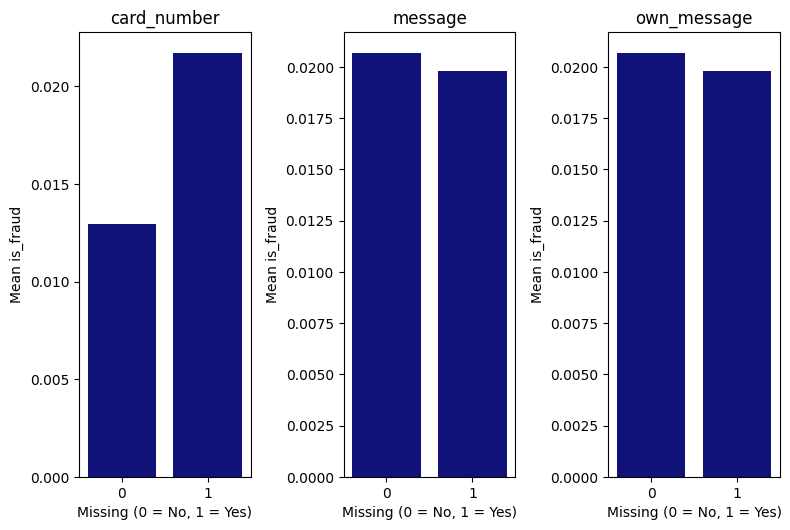

In [17]:
plt.figure(figsize=(8, 10))
df_copy = df.copy()

for i, col in enumerate(missing_column_pct.index, 1):
    df_copy[col+'_na'] = np.where(df_copy[col].isnull(), 1, 0)
    
    miss = df_copy.groupby(col+'_na')['is_fraud'].mean().reset_index()
    plt.subplot(2, 3, i)
    sns.barplot(data=miss, x=col+'_na', y='is_fraud', color='darkblue')
    plt.title(f'{col}')
    plt.xlabel('Missing (0 = No, 1 = Yes)')
    plt.ylabel('Mean is_fraud')

plt.tight_layout()
plt.show()

Missing values in these categorical columns strongly relate to fraud, so we may replace them with a new label to capture this information.

**3.2 Descriptive Analytics using SQL** 

In [18]:
import sqlite3

con = sqlite3.connect(':memory:')
df.to_sql('RAW_transaction_monitoring_merged', con, index=False)

10609

In [19]:
query = '''
select count (*) as total_transactions , count(distinct customer_id) as total_customers,
count(distinct currency) as currencies, Min(amount_eur) as Min_transaction, Max(amount_eur) as Max_transaction,
AVG (amount_eur) as avg_transaction
from RAW_transaction_monitoring_merged
'''
df_result = pd.read_sql_query(query,con)
df_result

,total_transactions,total_customers,currencies,Min_transaction,Max_transaction,avg_transaction
0,10609,1000,4,1.08347,20440.78,2629.328088


In [20]:
query = '''
select count(*) as fraud_count, sum (amount_eur) as fraud_amount
from RAW_transaction_monitoring_merged 
group by is_fraud
having is_fraud = 1
'''

df_result = pd.read_sql_query(query,con)
df_result

,fraud_count,fraud_amount
0,212,748943.51003


In [21]:
query = '''
with fraud_count as
(select strftime ('%w',transaction_date) as weekday,  is_fraud, count(*) as fraud_count
from RAW_transaction_monitoring_merged 
where is_fraud = 1
group by strftime ('%w',transaction_date), is_fraud)
,
total_count as
(select strftime ('%w',transaction_date) as weekday, count(*) as transaction_count
from RAW_transaction_monitoring_merged 
group by strftime ('%w',transaction_date)
)

select f.weekday, f.fraud_count, t.transaction_count,round(f.fraud_count*100.00 /t.transaction_count,2) as fraud_pct
from fraud_count f
join total_count t on f.weekday = t.weekday
'''

df_result = pd.read_sql_query(query,con)
df_result

,weekday,fraud_count,transaction_count,fraud_pct
0,3,81,5227,1.55
1,4,131,5382,2.43


**Descriptive Overview:**

- Total Records: **10,609** transactions with **212** fraudulent ones

- Customers: **1,000** unique customer IDs

- Currencies: 4 types used

- Minimum Transaction Amount: €1.08

- Maximum Transaction Amount: €20,440.78

- Average Transaction Amount: €2,629.32

- Fraudulent transaction amount: €74,8943

- Transactions had the lowest traffic on Wednesday (5,227 transactions, **1.55%** fraud) and the highest on Thursday (5,382 transactions, **2.42%** fraud).


In [22]:
query= '''
select 'Least_frequent_customer' as category, customer_id, transaction_count, total_amount
from 
(select *, sum(amount_eur) as total_amount, count(*) as transaction_count
from RAW_transaction_monitoring_merged
group by customer_id
order by count(*) asc
limit 1
)

UNION ALL

select 'Most_frequent_customer' as category, customer_id, transaction_count, total_amount
from 
(select *, sum(amount_eur) as total_amount,count(*) as transaction_count
from RAW_transaction_monitoring_merged
group by customer_id
order by count(*) desc
limit 1
)

'''
df_result = pd.read_sql_query(query,con)
df_result

,category,customer_id,transaction_count,total_amount
0,Least_frequent_customer,CUST00694,2,1126.353198
1,Most_frequent_customer,CUST00749,24,76208.780000


In [23]:
query = '''
select avg_amount_per_customer, rank
from
(select AVG(amount_eur) AS avg_amount_per_customer, rank() OVER(Order by  AVG(amount_eur) desc) as rank
FROM RAW_transaction_monitoring_merged
group by customer_id
order by  AVG(amount_eur) desc)
where rank = 1
or rank = 1000
'''

df_result = pd.read_sql_query(query,con)
df_result

,avg_amount_per_customer,rank
0,14649.239091,1
1,18.810629,1000


**Customer Behavior Insights:**

   - Each customer made between 2 and 24 transactions.
   
   - Customer `CUST00694` made the least frequent transaction (2) with an amount of €1,126, while `CUST00749` made the most frequent transactions (23) with a total of €76,208.

   - Average transaction amount per customer ranges from approximately €18 to €14,649.

**3.3 Univariate and Bivariate analysis**

**Numerical Variables (Discrete)**

In [24]:
discrete_variable = df.select_dtypes(include='int').columns.to_list() 
discrete_variable

['is_fraud', 'transaction_count']

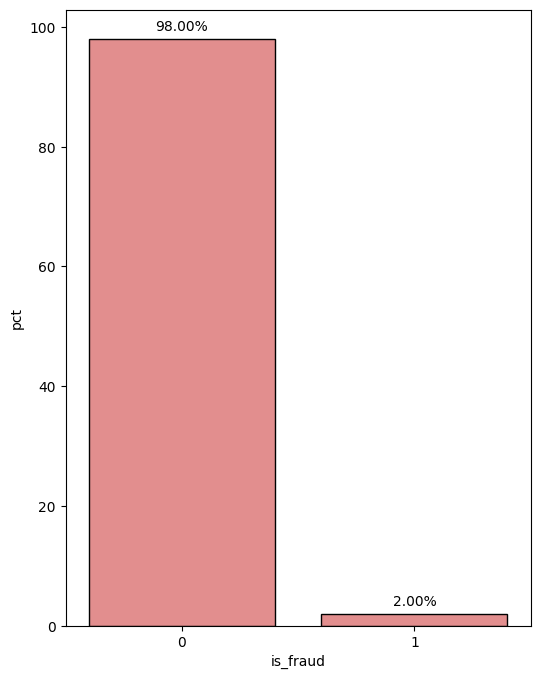

In [25]:
fraud_counts = (100.00* df['is_fraud'].value_counts()/ len(df)).sort_index()
fraud_df = fraud_counts.reset_index()
fraud_df.columns = ['is_fraud','pct']

plt.figure (figsize=(6,8))
ax = sns.barplot(fraud_df, x='is_fraud', y='pct',color='lightcoral', edgecolor='black')

for index,row in fraud_df.iterrows():
    ax.text (x=index, y=row['pct'] + 0.9, s=f"{row['pct']:.2f}%", ha='center', va='bottom')

plt.show()

`is_fraud` has an imbalanced dataset, with few positive (fraud) cases compared to negatives.

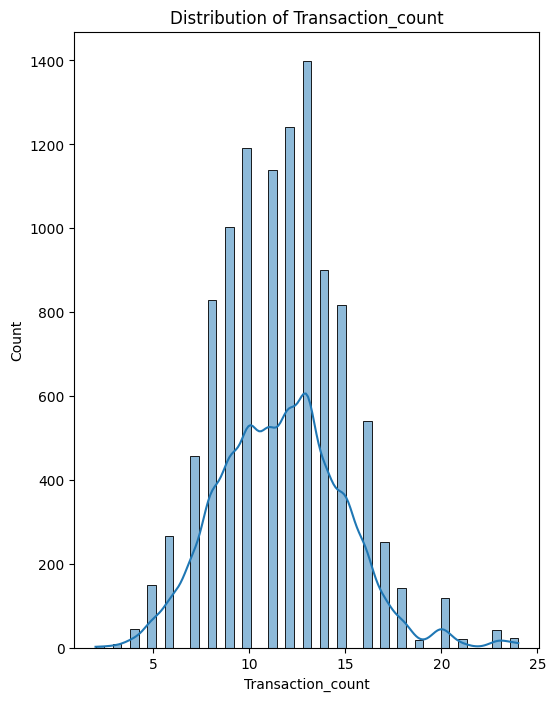

In [26]:
plt.figure(figsize=(6,8))
sns.histplot(df['transaction_count'], kde=True)
plt.title('Distribution of Transaction_count')
plt.xlabel('Transaction_count')
plt.ylabel('Count')
plt.show()

`Transaction_count` seems to follow a Gaussian distribution.

**Numerical Variables (Continuous)**

In [27]:
continuous_variable = df.select_dtypes(include='float').columns.to_list()
print(continuous_variable)

['amount_eur', 'available_balance_eur', 'value_dated_balance_eur', 'credit_limit_eur', 'total_volume_eur', 'avg_amount_eur', 'max_amount_eur', 'min_amount_eur']


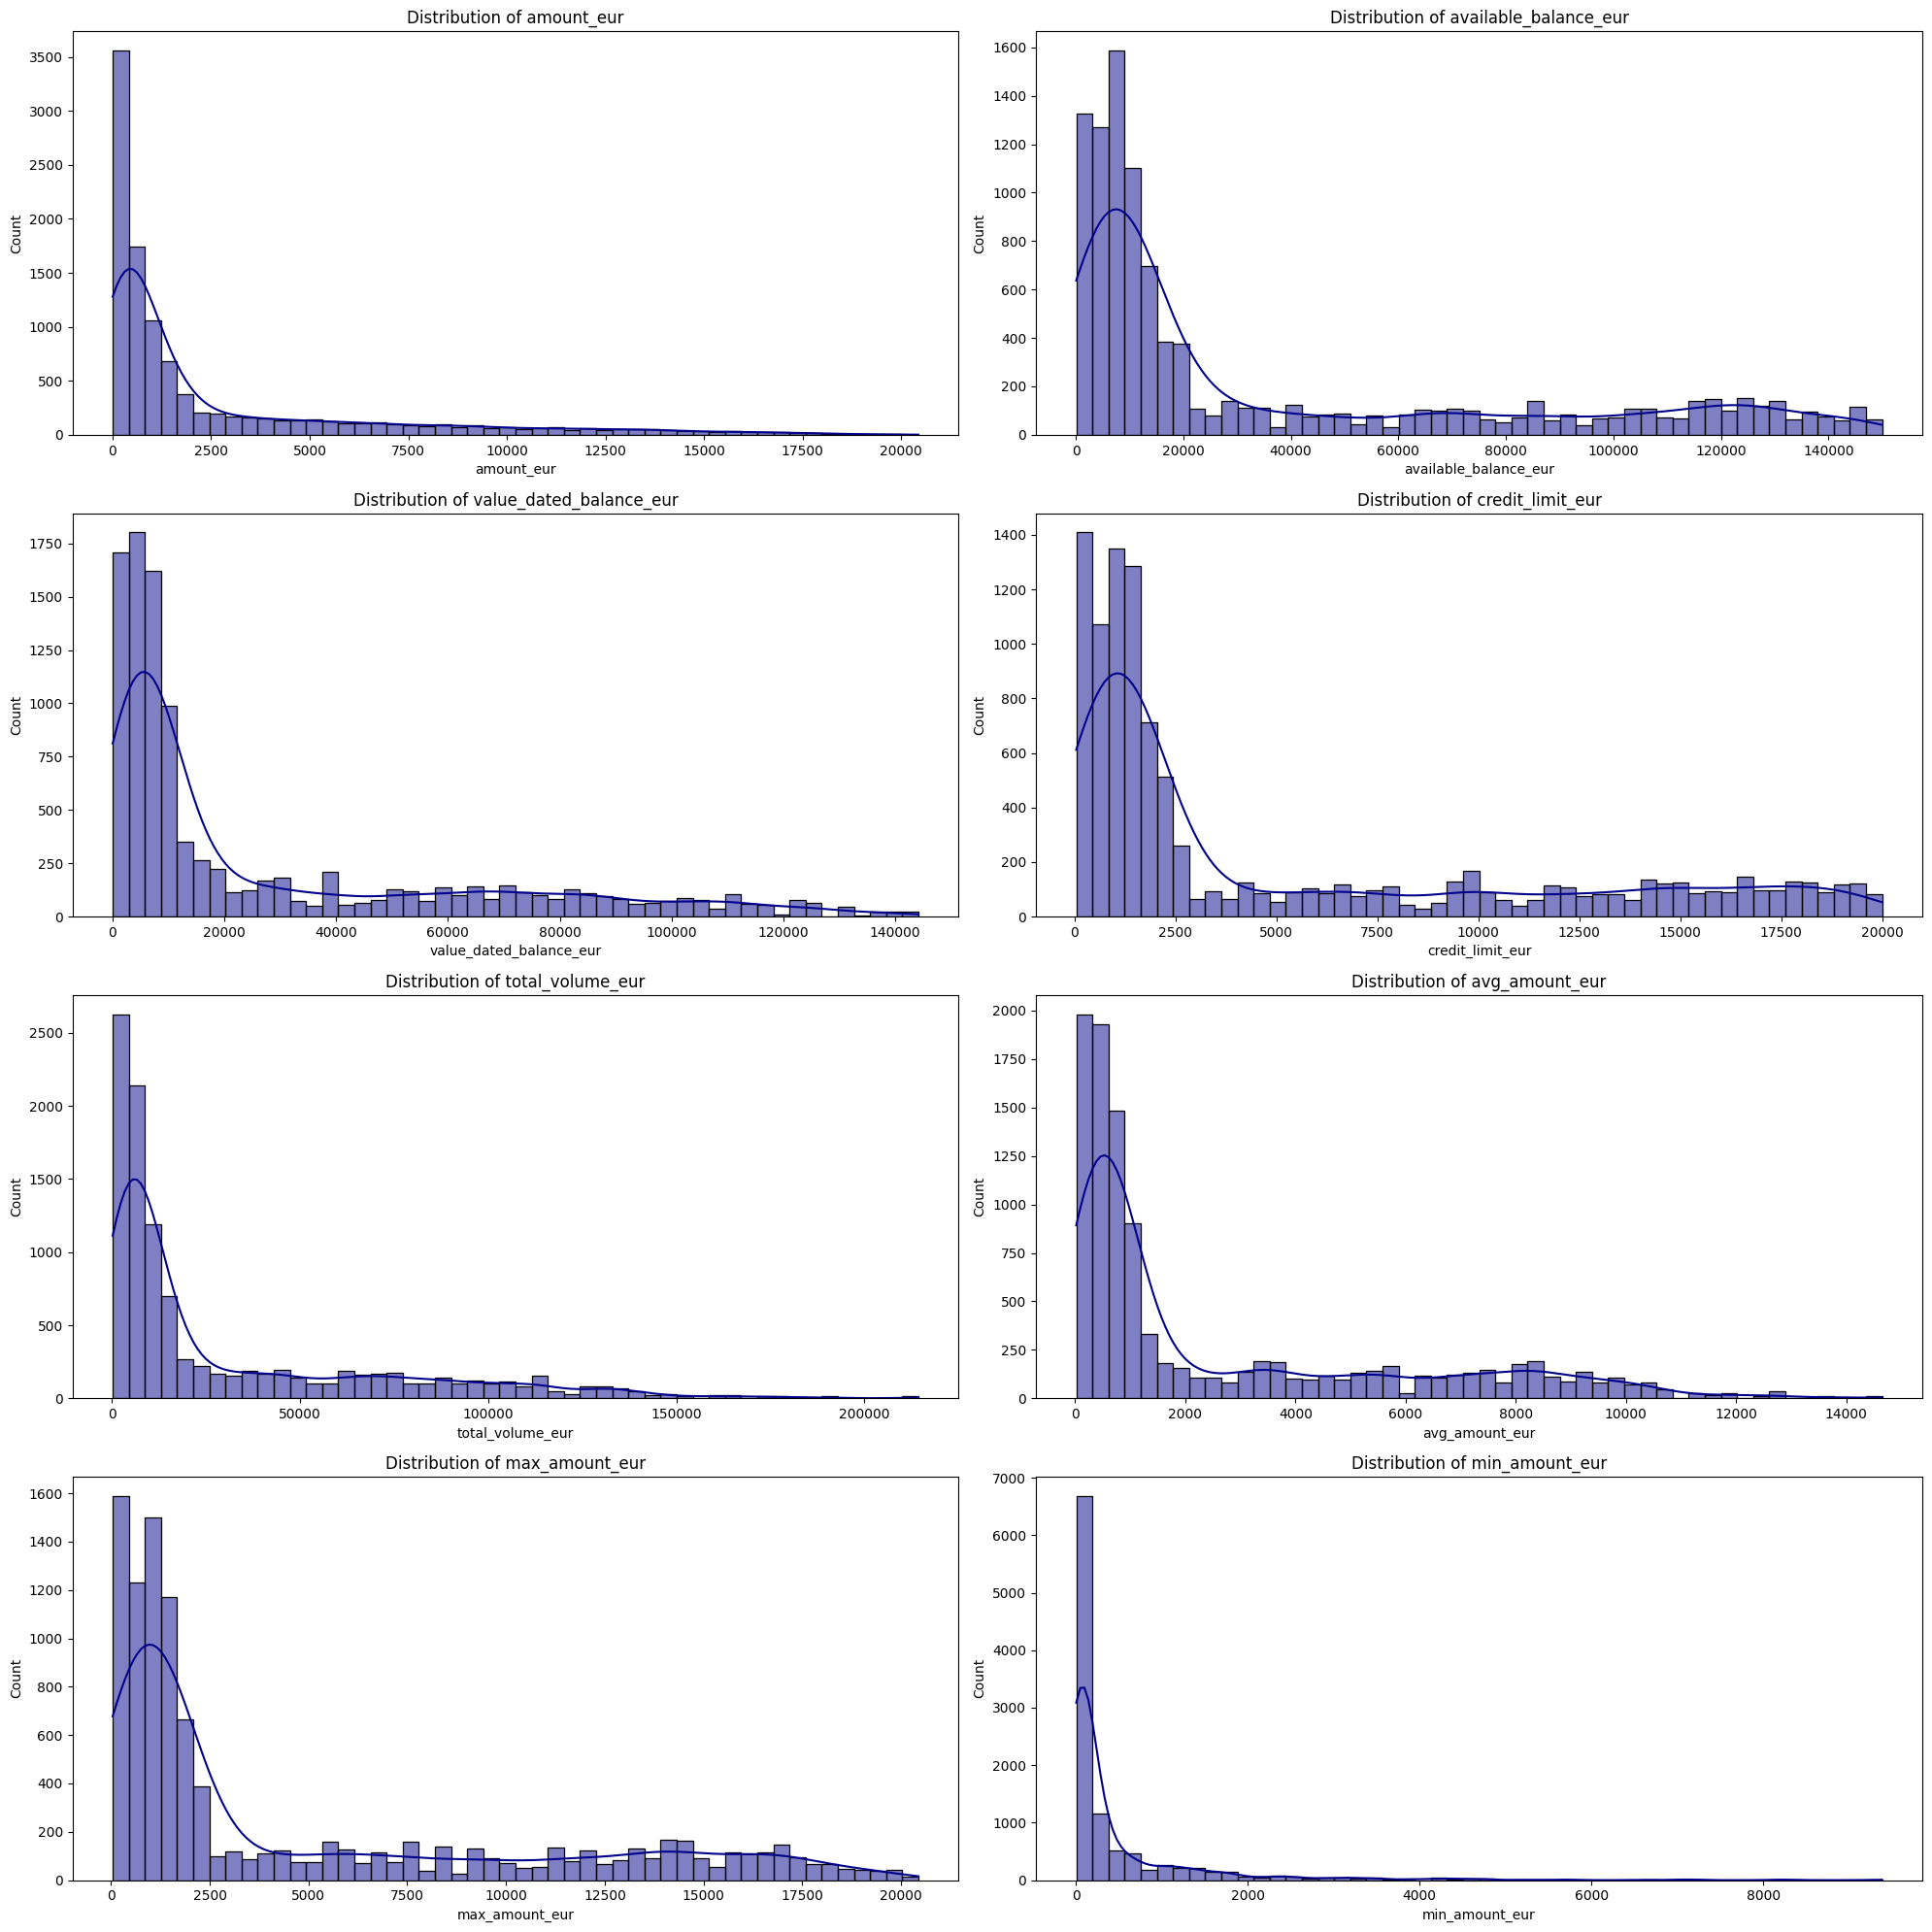

In [28]:
#Let’s explore these Continuous features further.
plt.figure(figsize=(20, 20))
for i, col in enumerate(continuous_variable,1):
      df_copy = df.copy()
      plt.subplot(4, 2, i)
      sns.histplot(df_copy[col], bins=50, kde=True, color='darkblue')
      plt.title(f'Distribution of {col}')
      plt.xlabel(col)
      plt.ylabel('Count')

plt.tight_layout()
plt.show()

Most of the columns are skewed, so transformation is necessary.

In [29]:
corr_matrix_con = df[continuous_variable].corr()
corr_matrix_con

,amount_eur,available_balance_eur,value_dated_balance_eur,credit_limit_eur,total_volume_eur,avg_amount_eur,max_amount_eur,min_amount_eur
amount_eur,1.000000,0.482424,0.468105,0.804914,0.778334,0.824899,0.808773,0.585402
available_balance_eur,0.482424,1.000000,0.972171,0.606589,0.538830,0.583781,0.600441,0.327843
value_dated_balance_eur,0.468105,0.972171,1.000000,0.587046,0.527878,0.566313,0.580136,0.323334
credit_limit_eur,0.804914,0.606589,0.587046,1.000000,0.921264,0.975270,0.991295,0.625850
total_volume_eur,0.778334,0.538830,0.527878,0.921264,1.000000,0.943826,0.932974,0.608655
avg_amount_eur,0.824899,0.583781,0.566313,0.975270,0.943826,1.000000,0.979956,0.709265
max_amount_eur,0.808773,0.600441,0.580136,0.991295,0.932974,0.979956,1.000000,0.625172
min_amount_eur,0.585402,0.327843,0.323334,0.625850,0.608655,0.709265,0.625172,1.000000


These independent variables are highly correlated; we may want to perform feature selection.

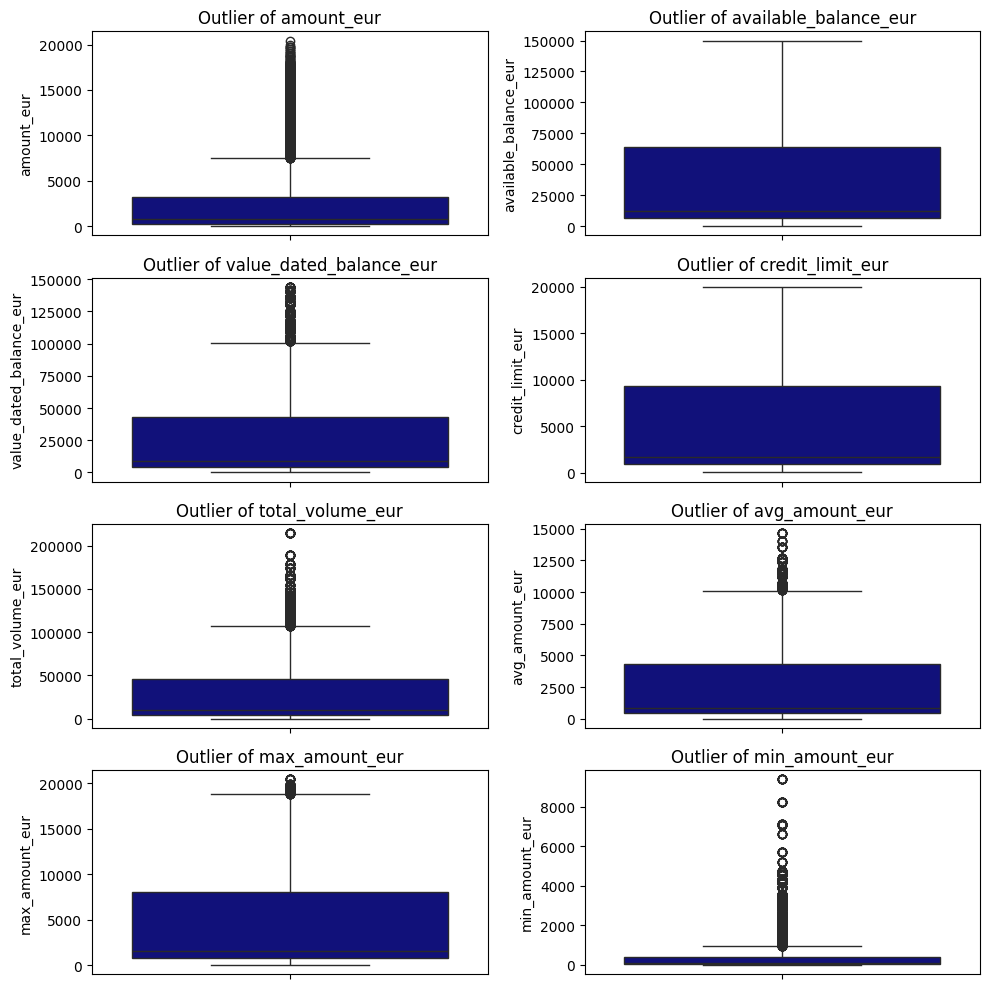

In [30]:
plt.figure(figsize=(10,10))

for i,col in enumerate(continuous_variable,1):
  df_copy = df.copy()
  plt.subplot (4,2,i)
  sns.boxplot(df_copy[col], color='darkblue')
  plt.title(f"Outlier of {col}")

plt.tight_layout()
plt.show()

Most columns have outliers. We need to be mindful of this when handling missing data, especially if there are any continuous features. Additionally, we need to apply some methods to handle these outliers.

In [31]:
corr_matrix = df[continuous_variable + ['is_fraud']].corr()['is_fraud'].sort_values(ascending=False)
corr_matrix

is_fraud                   1.000000
amount_eur                 0.033166
min_amount_eur             0.008269
available_balance_eur      0.004858
value_dated_balance_eur    0.003459
avg_amount_eur             0.001273
max_amount_eur             0.000737
total_volume_eur          -0.000014
credit_limit_eur          -0.004218
Name: is_fraud, dtype: float64

`amount_eur` has the strongest positive relationship with the target variable `is_fraud`.

**Temporal Variables (Datetime Variables)**

We identify datetime columns from object types, convert them to the correct datetime format, and then transform them into numeric columns.

In [32]:
from pandas.api.types import is_datetime64_any_dtype

date_col = []
for col in df_copy.columns: 
    if df_copy[col].dtypes == 'O':
      try:
         convert = pd.to_datetime(df_copy[col])
         if is_datetime64_any_dtype(convert):
              date_col.append(col)
      except Exception: 
         continue
print (date_col)

['transaction_date', 'value_date', 'payment_date', 'booking_date', 'latest_transaction_booking_date', 'dob', 'last_transaction_date']


Since the data retrieves transactions within a 2-day period (April 2–4, 2025), we will not extract the month and year.

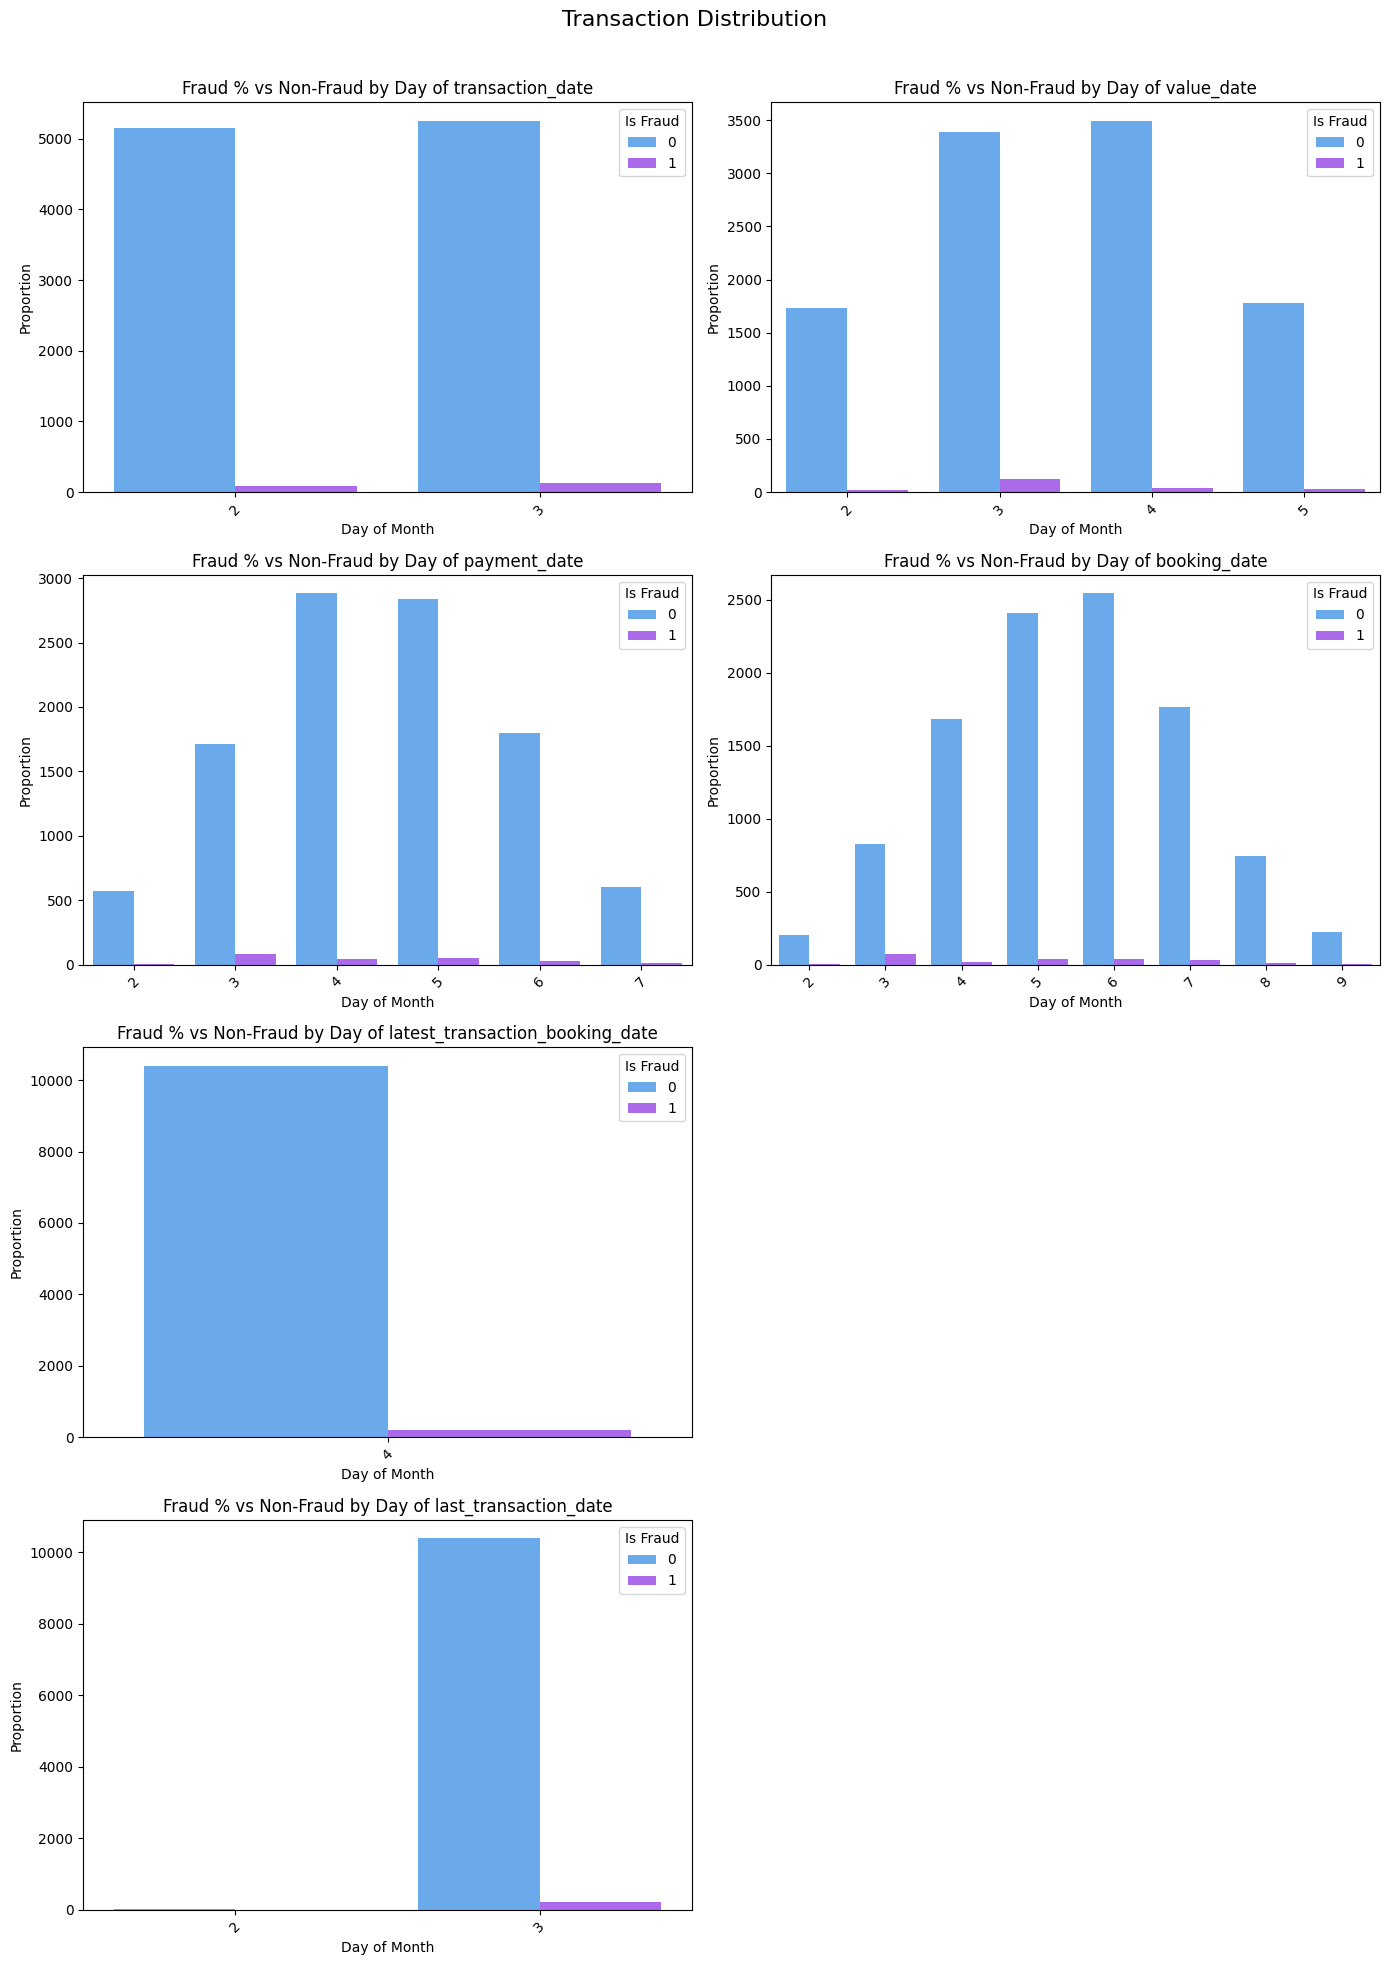

In [33]:
plt.figure(figsize=(14, 20))

for i, col in enumerate(date_col, 1):
    df_copy[col] = pd.to_datetime(df_copy[col])
    if col != 'dob':
        df_copy[col+'_day'] = df_copy[col].dt.day
        df_plot = (df_copy.groupby(col+'_day')['is_fraud'].value_counts().rename('fraud_rate').reset_index(name='fraud_rate'))
        plt.subplot(4, 2, i)
        sns.barplot(data=df_plot,x=col+'_day',y='fraud_rate',hue='is_fraud',palette='cool'
        )

        plt.title(f'Fraud % vs Non-Fraud by Day of {col}', fontsize=12)
        plt.xlabel('Day of Month', fontsize=10)
        plt.ylabel('Proportion', fontsize=10)
        plt.xticks(rotation=45)
        plt.legend(title='Is Fraud', loc='upper right')

plt.suptitle('Transaction Distribution', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


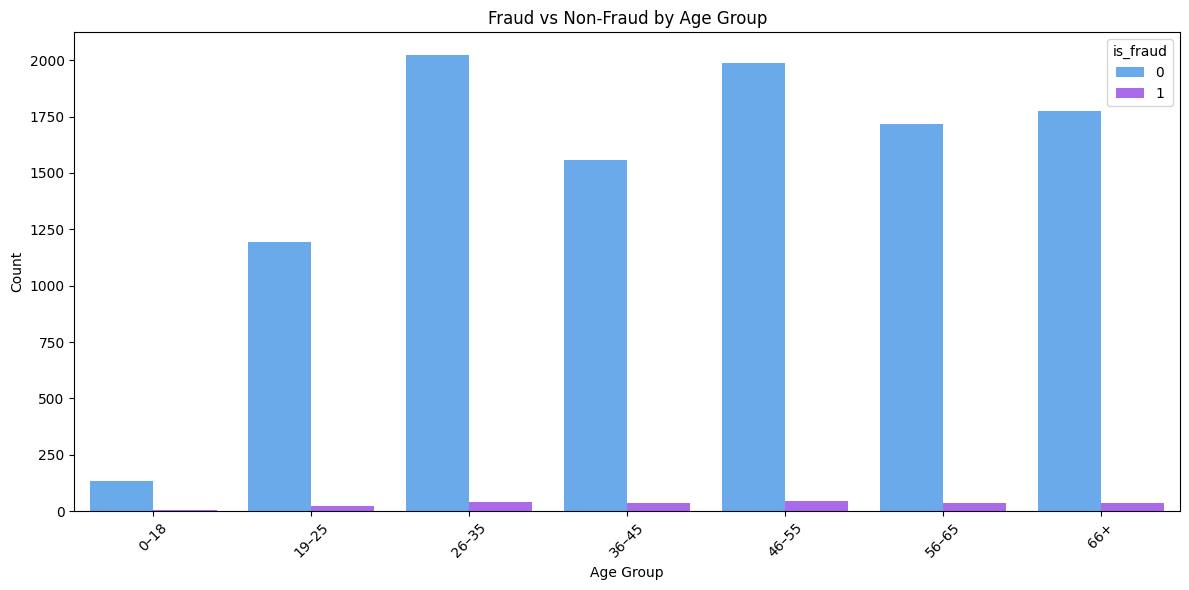

In [34]:
df_copy['dob'] = pd.to_datetime(df['dob'])
today = datetime.today()
df_copy['age'] = (
    today.year - df_copy['dob'].dt.year -
    ((df_copy['dob'].dt.month > today.month) | 
     ((df_copy['dob'].dt.month == today.month) & (df_copy['dob'].dt.day > today.day)))
)
bins = [0, 18, 25, 35, 45, 55, 65, 75]
labels = ['0–18', '19–25', '26–35', '36–45', '46–55', '56–65', '66+']
df_copy['age_bin'] = pd.cut(df_copy['age'], bins=bins, labels=labels)

df_plot = df_copy.groupby('age_bin')['is_fraud'].value_counts().reset_index(name='count')

plt.figure(figsize=(12, 6))
sns.barplot(data=df_plot, x='age_bin', y='count', hue='is_fraud', palette='cool')
plt.title('Fraud vs Non-Fraud by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.show()

**Categorical Variables**

In [35]:
categorical_variable = df.select_dtypes(include='object').columns.to_list()

Let’s identify the number of unique categories in each categorical (object) column.

In [36]:
for feature in categorical_variable: 
    count_value = df[feature].nunique()
    print (feature,'-', count_value,'categories')

customer_id - 1000 categories
transaction_id - 10609 categories
currency - 4 categories
transaction_date - 10222 categories
value_date - 10339 categories
payment_date - 10403 categories
booking_date - 10423 categories
type_description - 5 categories
transaction_type - 5 categories
narrative - 9796 categories
status_x - 1 categories
counterparty_name - 8373 categories
card_number - 2084 categories
message - 1 categories
own_message - 1 categories
country - 5 categories
account_numbers - 1000 categories
account_name - 997 categories
product - 3 categories
account_type - 2 categories
status_y - 1 categories
latest_transaction_booking_date - 1 categories
registration_number - 1000 categories
dob - 972 categories
residence_country - 5 categories
occupation - 10 categories
gender - 3 categories
bank.name - 1 categories
bank.bic - 1 categories
bank.country - 5 categories
last_transaction_date - 987 categories


In [37]:
df.to_csv('data/EDA_transaction_monitoring_merged.csv',index=False)